# Import and loading

In [48]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.evaluator import Evaluator

import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD, IncrementalPCA, TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.svm import SVR, SVC
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import prince
import numpy as np

In [2]:
data = Loader.load_by_fueltype("Combustion")

c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[co

# Functions

In [3]:
def drop_columns_full_nan(data: pd.DataFrame) -> pd.DataFrame:
    #Remove the column that only contain NAs
    cols_to_drop = data.columns[data.isna().all()]
    data = data.drop(cols_to_drop, axis=1)
    return data

def get_combustion_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])

    #if all the values of the numerical columns is 0, we rem['Combustion']ove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)
    return numerical_columns

def fill_combustion_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    cols_mode = ['displacement_liters','doors','seatingCapacity','number_of_cylinders','cubicCapacity',"dimensions.length","dimensions.height","Llantas_Diametro_cm","number_of_cylinders","bore_diameter","stroke_length"]
    #fill the elemental columns that has a minor amount of missing data with the mode
    for col in cols_mode:
        numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, col)

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="rpm_max_torque")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="rpm_max_power")
    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_combustion_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Select and print only the categorical columns
    ret = df.select_dtypes(include=['category'])
    
    # Temporarily convert the column to strings to perform the replacement
    ret['traction'] = ret['traction'].astype(str).replace({"trasera": "trasero", "delantera": "delantero"})
    # Convert back to a categorical type
    ret['traction'] = ret['traction'].astype('category')

    
    # Remove redundant columns if this function is defined
    ret = Data_processor.remove_redundand_columns(ret)
    return ret


def fill_combustion_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    mode_cols = ['brakes','version','jato_classification']
    for col in mode_cols:
        df = Data_processor.fill_na_with_mode(df, col)
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model"] , Y="environmentalLabel")
    return df

def category_convert(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_convert = df.select_dtypes(include=['object']).columns
    for col in cols_to_convert:
        df[col] = df[col].astype('category')
    return df


# Column filters

In [4]:
# Quit all electric columns from data['Combustion']
for column in data.columns:
    if column.startswith('electric'):
        data = data.drop(columns=column)

In [5]:
# convert object columns to category
data = category_convert(data)

categorical_columns = get_combustion_categorical_columns(data)

categorical_columns = fill_combustion_categorical_columns(categorical_columns)

# Check amount of missing values
missing_values = categorical_columns.isnull().sum()
missing_values = missing_values[missing_values > 0]

print(missing_values)
categorical_columns.head()
categorical_columns.columns
#categorical_columns['traction']

Series([], dtype: int64)


Index(['color', 'brand', 'model', 'version', 'fuelType', 'bodyTypeId',
       'transmissionTypeId', 'province', 'environmentalLabel',
       'jato_classification', 'traction', 'brakes', 'front_suspension',
       'rear_suspension', 'Acabado Exterior_Alerón',
       'Acabado Exterior_Cristales', 'Acabado Exterior_Faldones',
       'Acabado Exterior_Pintura', 'Acabado Exterior_Rueda', 'AC_Zones',
       'AC_Type', 'Metodo_Apertura', 'Tipo_Faro', 'interior_clock',
       'arm_suppport_front', 'arm_suppport_back', 'price_categ'],
      dtype='object')

In [6]:
# Drop all na columns 
data = drop_columns_full_nan(data)

numerical_columns = get_combustion_numerical_columns(data)


# fill the missing data in numerical columns
numerical_columns = fill_combustion_numerical_columns(numerical_columns)

# Check amount of missing values
missing_values_num = numerical_columns.isnull().sum()
missing_values_num = missing_values_num[missing_values_num > 0]

data[numerical_columns.columns] = numerical_columns

#correlation_matrix = numerical_columns.corr()
#correlation_matrix = correlation_matrix.sort_values(by='price', ascending=False)
print(missing_values_num)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.6154091221985554%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 17.70914536272189%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 6.410215656255401%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 7.903819131160218%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 6.824540773438649%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 2.55180902596012e+16%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> rpm_max_torque: 67.97560330482807%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> rpm_max_power: 20.028480167086347%
Series([], dtype: int64)


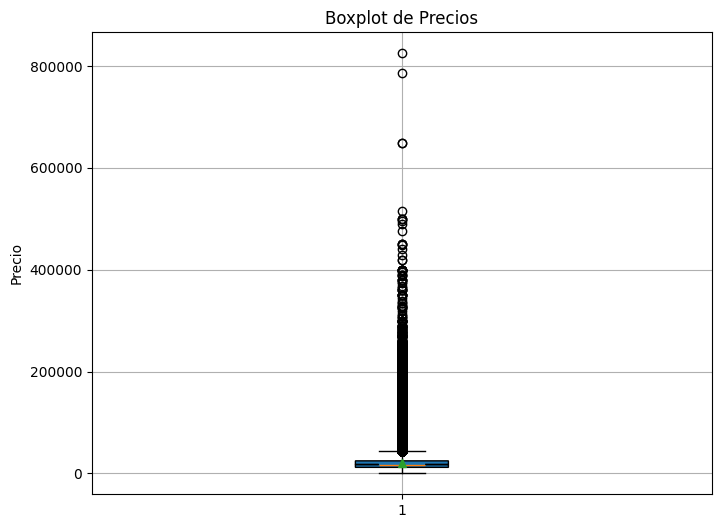

In [7]:
precios_combustion = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_combustion, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

Even though there seems to be many outliers in the data, after a manual inspection, it was found that the data is correct and the outliers are valid data points. (Most of them are from luxury brands such as Lamborghini, Ferrari, etc.)

In [8]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)[:10]

43901.5


,price,brand
idx,,
48458,825000,MERCEDES-BENZ
38166,786500,FERRARI
16685,648500,FERRARI
18873,648500,FERRARI
119510,515000,PORSCHE
16086,499900,FERRARI
78396,499900,LAMBORGHINI
76218,499900,LAMBORGHINI
19151,495000,LAMBORGHINI


# PCA

In [9]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [10]:
principal_components

array([[-0.94936538, -1.95424871],
       [-0.09526035, -0.50605691],
       [12.15540408,  3.56908054],
       ...,
       [-0.97962288, -0.29182012],
       [-3.21372284,  2.53701734],
       [-4.00545634, -1.52924421]])

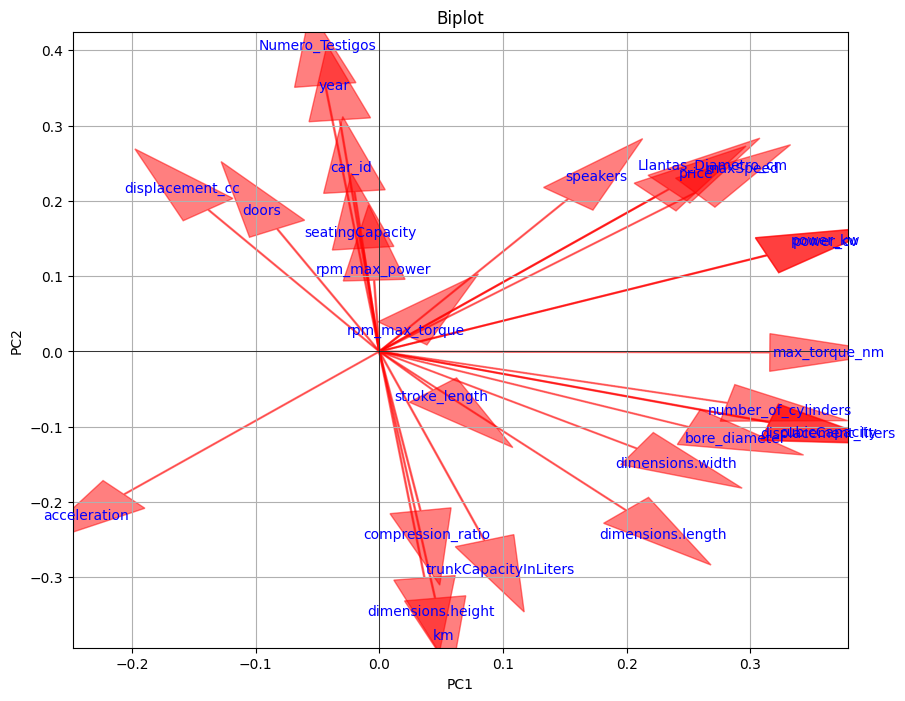

In [11]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

# Test CART regression trees with only numerical variables

In [12]:
X = numerical_columns.drop(columns="price")
y = numerical_columns["price"]

# Since too many features + rows are present, we will use PCA to reduce the dimensionality
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Check PCA-transformed data
print(f"Original shape: {X.shape}, Transformed shape: {X_pca.shape}")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

Original shape: (129204, 26), Transformed shape: (129204, 17)


DecisionTreeRegressor(random_state=42)

MAE: 2275.2995339521353 
 MSE: 57882217.11892269 
 RMSE: 7608.036351051609 
 R2: 0.8693807758805843 
 MAPE: 12.033195862303094
Mean: 2275.2995339521353
Variance: 52705229.14971987
Standard Deviation: 7259.836716464074


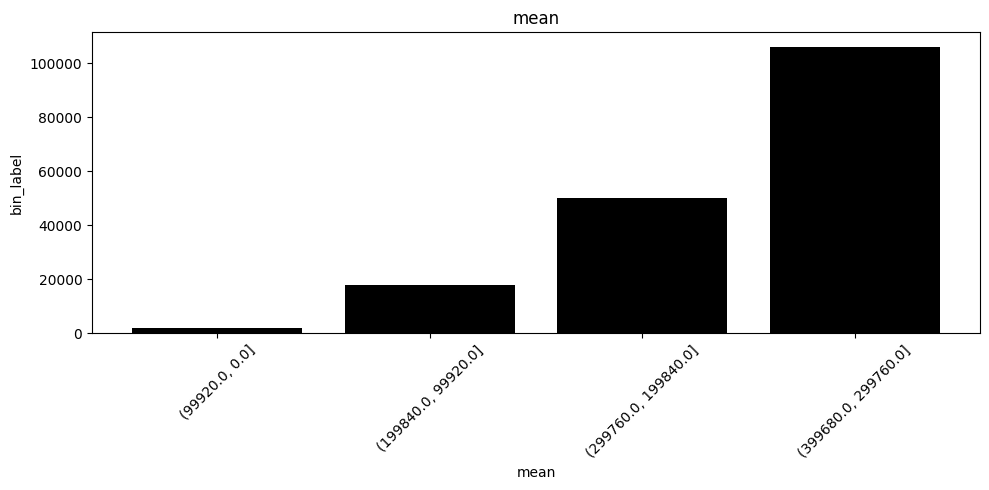

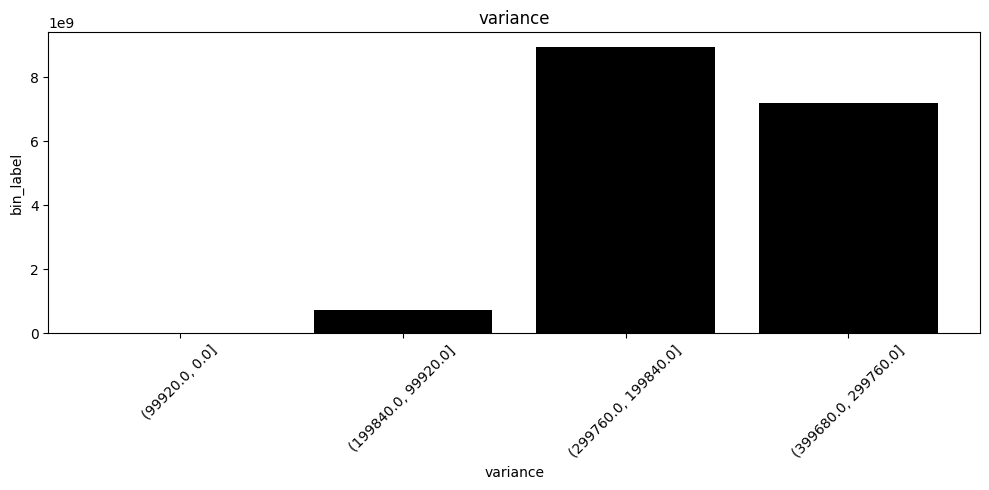

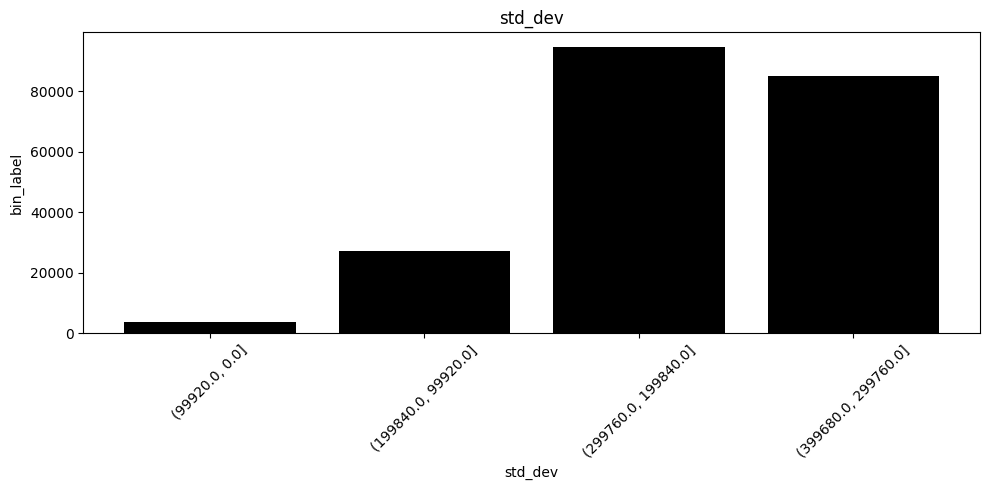

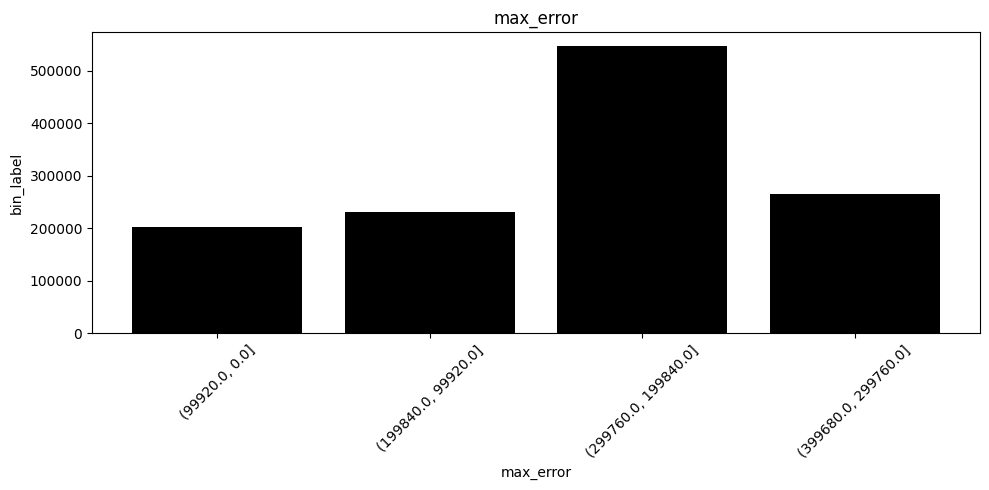

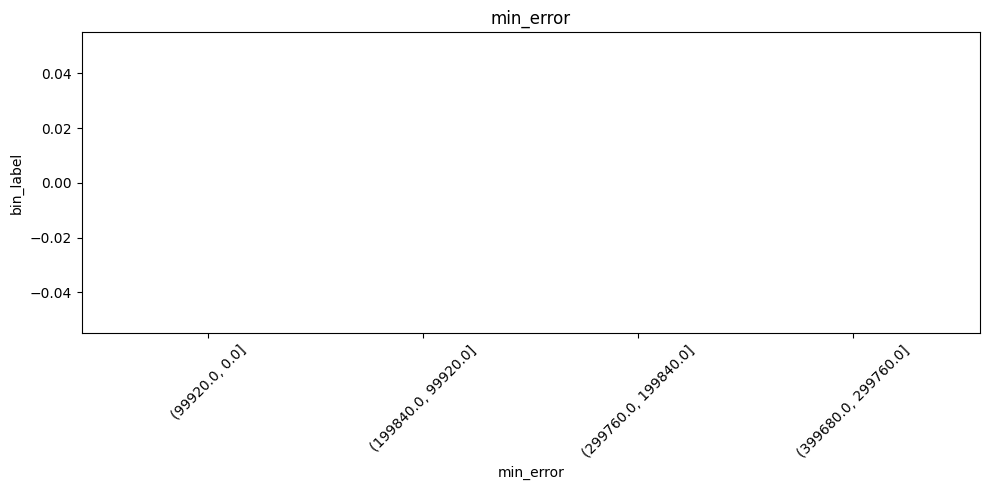

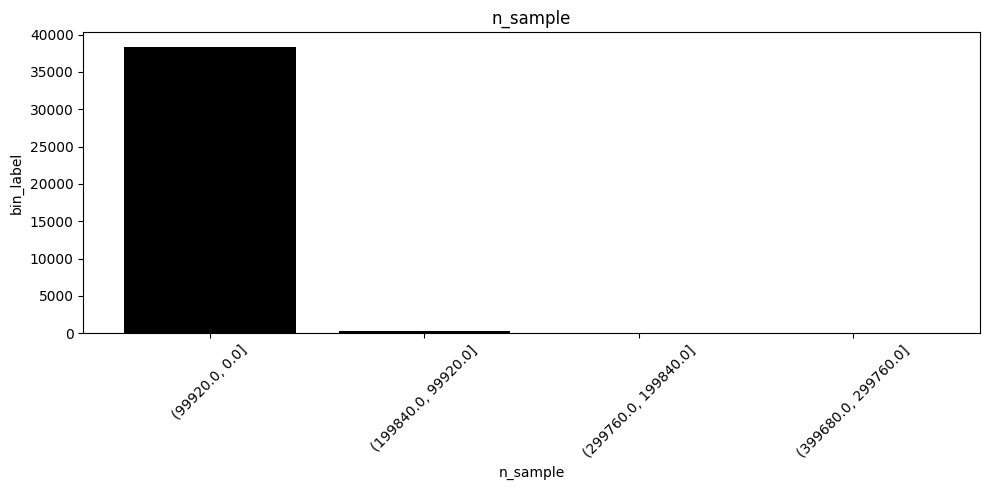

,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(99920.0, 0.0]",2010.565162,1.425405e+07,3775.453800,203000.0,0.0,38374
1,"(199840.0, 99920.0]",17904.078125,7.468283e+08,27328.158704,230900.0,0.0,288
2,"(299760.0, 199840.0]",49946.071429,8.958611e+09,94649.937944,546500.0,0.0,77
3,"(399680.0, 299760.0]",106106.312500,7.197967e+09,84840.833685,266000.0,0.0,16


In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Realizar predicciones sobre el conjunto de prueba
y_pred = tree_model.predict(X_test)

Evaluator.eval_regression(y_pred, y_test)

# CA

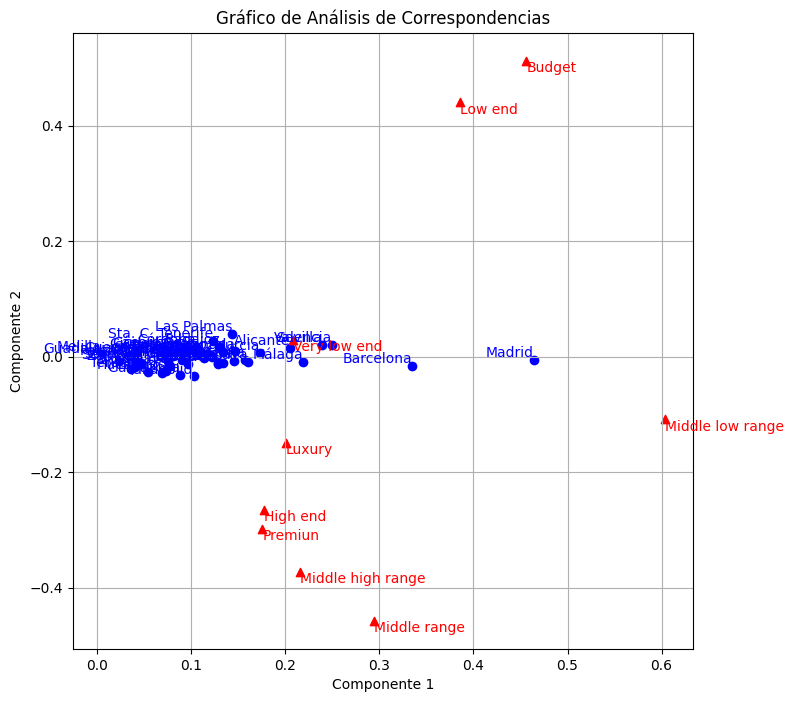

In [14]:
Data_processor.CA(categorical_columns=categorical_columns, col_x="province", col_y="price_categ")

In [15]:
categorical_columns["price_categ"].value_counts()

price_categ
Middle low range     47015
Budget               26867
Low end              19272
Middle range         11219
Middle high range     6014
Very low end          5609
Luxury                5182
High end              4049
Premiun               3977
Name: count, dtype: int64

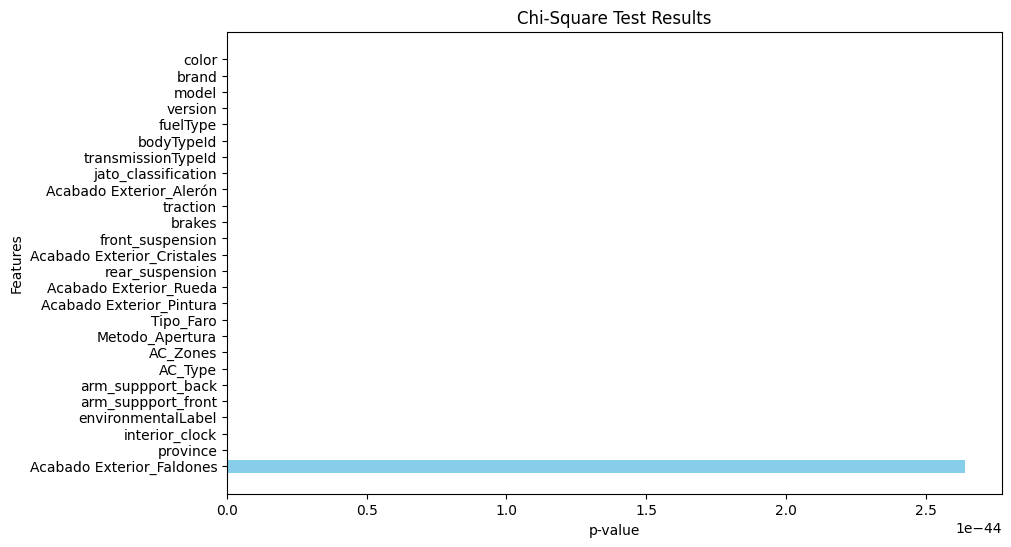

Index(['color', 'brand', 'model', 'version', 'fuelType', 'bodyTypeId',
       'transmissionTypeId', 'jato_classification', 'Acabado Exterior_Alerón',
       'traction', 'brakes', 'front_suspension', 'Acabado Exterior_Cristales',
       'rear_suspension', 'Acabado Exterior_Rueda', 'Acabado Exterior_Pintura',
       'Tipo_Faro', 'Metodo_Apertura', 'AC_Zones', 'AC_Type',
       'arm_suppport_back', 'arm_suppport_front', 'price_categ'],
      dtype='object')

In [16]:
categorical_columns = Data_processor.chi_square_filter(categorical_columns, "price_categ", p_value_filter=0)
categorical_columns.columns

# Categorical

## Test CART tree classifier with only categorical values

In [17]:
features_df = pd.get_dummies(categorical_columns.drop('price_categ', axis=1))

# Your target variable
target = categorical_columns['price_categ'].apply(Loader.encode_price_categ)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree Classifier
cart_model = DecisionTreeClassifier(random_state=42)
cart_model.fit(X_train, y_train)

# Predicting the test set results
y_pred = cart_model.predict(X_test)

In [18]:
result = pd.DataFrame({"Real_Categorie": y_test, "Prediction": y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result

,Real_Categorie,Prediction,diff
idx,,,
35700,Budget,Budget,0
157809,Budget,Budget,0
46442,Low end,Low end,0
164823,Budget,Budget,0
104592,Budget,Budget,0
...,...,...,...
76424,Middle low range,Middle low range,0
148454,Middle low range,Middle low range,0
72048,Luxury,High end,2


In [19]:
# Calcular la precisión
Evaluator.eval_classfication(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.7073164439399412 
 Precision: 0.7041710782742121 
 Recall: 0.7073164439399412 
 F1 Score: 0.7054595466776329
Confusion Matrix:
 [[11637    35   114     6   109  1461   689    24    12]
 [   75   520     2    31   291     3   148   196     0]
 [  128     1  4052     3     3  1076     4     2   476]
 [   14    35     3  1276    17     3     9   194     2]
 [  199   216     2     9   804     7   467    57     1]
 [ 1336     2  1227     0     3  5512    17     2    29]
 [ 1117    82    10     8   343    20  1805    31     2]
 [   29   191     2   131    83     4    57   641     1]
 [   14     0   450     0     2    27     0     1  1170]]


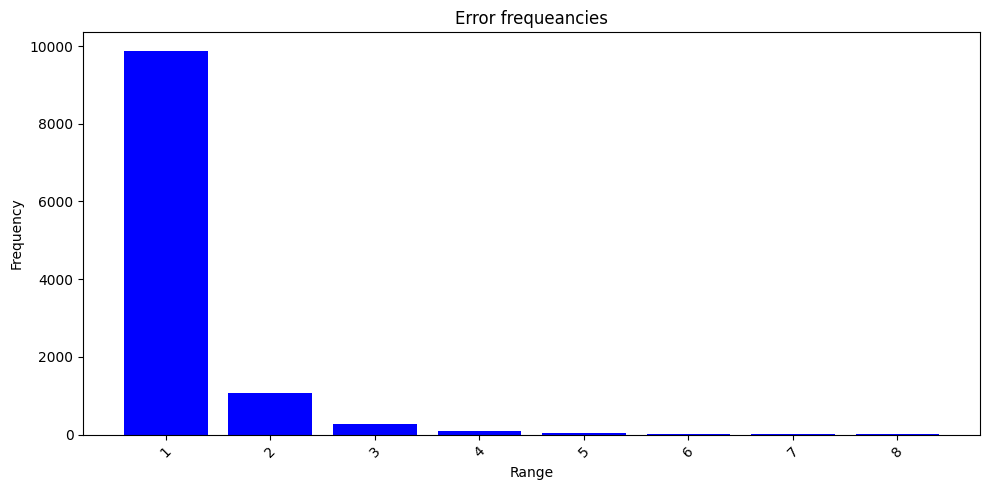

{np.int64(1): np.int64(9861), np.int64(2): np.int64(1079), np.int64(3): np.int64(274), np.int64(4): np.int64(82), np.int64(5): np.int64(32), np.int64(6): np.int64(7), np.int64(7): np.int64(8), np.int64(8): np.int64(2)}
Error mean: 1.1849272807404143
Error rate: 29.26835560600588 %
Overall mean: 0.3468087301996801


In [20]:
Evaluator.eval_ordinal_classification (result["diff"])

Even though the accuracy is only about 70% the errors are not a concern as many of the errors are of degree 1 (the guess was not far off)

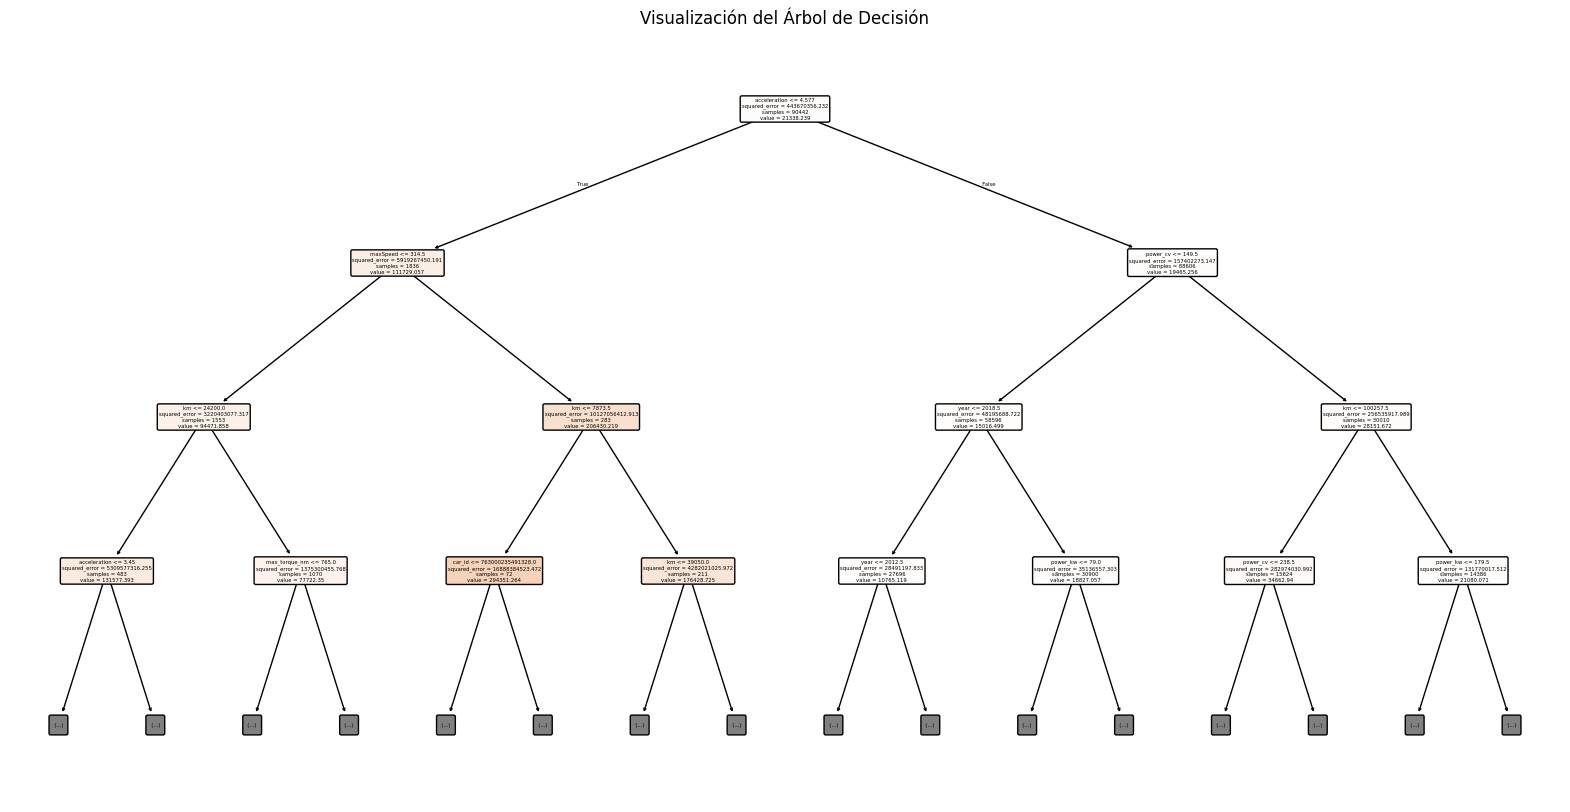

In [21]:
plt.figure(figsize=(20,10))

# Dibujar el árbol de decisión
plot_tree(tree_model, 
          filled=True, 
          rounded=True, 
          class_names=X_train.columns, 
          feature_names=X.columns, 
          max_depth=3)  # Puedes ajustar la profundidad para una mejor visualización o quitar este parámetro para mostrar todo el árbol
plt.title('Visualización del Árbol de Decisión')
plt.show()

In [22]:
# Merge numerical and categorical columns
combustion_cars = pd.merge(numerical_columns, categorical_columns, left_index=True, right_index=True, how="inner")
numerical_column_names = list(numerical_columns.columns)
categorical_column_names = list(categorical_columns.columns)

# Separate target variables
target = combustion_cars[["price", "price_categ"]]
combustion_cars.drop(columns=["price", "price_categ"], inplace=True)

# Update feature lists by removing targets
numerical_column_names.remove("price")
categorical_column_names.remove("price_categ")

# Initialize dictionary to store encoders/scalers
encoders_and_scalers = {}

# Scale and apply PCA to numerical columns
numerical_data = combustion_cars[numerical_column_names]
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

# Apply IncrementalPCA to numerical data
incremental_pca_numerical = PCA(n_components=0.95)
numerical_data_pca = incremental_pca_numerical.fit_transform(numerical_data_scaled)

# Store the scaler and PCA for numerical columns
encoders_and_scalers["numerical_scaler"] = scaler
encoders_and_scalers["numerical_pca"] = incremental_pca_numerical

# Encode categorical columns (sparse matrix)
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
categorical_data_encoded = encoder.fit_transform(combustion_cars[categorical_column_names])

# Instead of PCA on categorical data, use TruncatedSVD for sparse matrix
svd_categorical = TruncatedSVD(n_components=30)
categorical_data_svd = svd_categorical.fit_transform(categorical_data_encoded)

# Store the encoder and SVD for categorical columns
encoders_and_scalers["categorical_encoder"] = encoder
encoders_and_scalers["categorical_svd"] = svd_categorical

# Combine the PCA-transformed numerical and SVD-transformed categorical data
combustion_cars_encoded = pd.DataFrame(
    data=np.hstack([numerical_data_pca, categorical_data_svd]),
    index=combustion_cars.index
)

print("Shape after dimensionality reduction:")
print(combustion_cars_encoded.shape)




Shape after dimensionality reduction:
(129204, 47)


## Classification

In [23]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combustion_cars_encoded, target['price_categ'], test_size=0.3, random_state=42)

In [24]:
def eval_classification(y_test, y_pred):
    result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
    result["diff"] = result["Real"].apply(Loader.encode_price_categ).to_numpy() - result["Prediction"].apply(Loader.encode_price_categ).to_numpy()
    Evaluator.eval_ordinal_classification(diff=result["diff"])

def classify(X_train, X_test, y_train, y_test , classifier, classifier_name = None) -> None:
    classifier = classifier
    classifier.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = classifier.predict(X_test)
    eval_classification(y_test, y_pred)

    if classifier_name != None:
        return Evaluator.eval_classfication(y_pred = y_pred, y_true=y_test, binary_classification=False, classifier_name=classifier_name)
    return Evaluator.eval_classfication(y_pred = y_pred, y_true=y_test, binary_classification=False)

## Cart

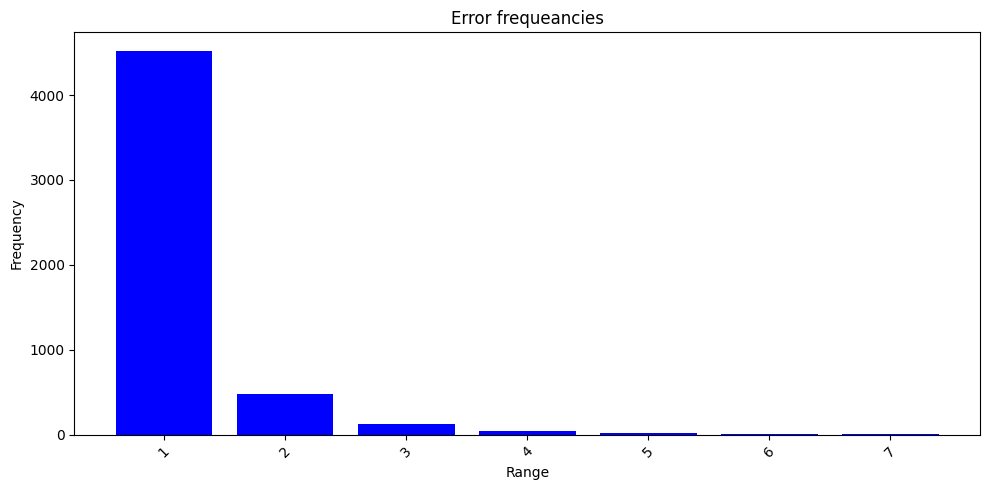

{np.int64(1): np.int64(4514), np.int64(2): np.int64(472), np.int64(3): np.int64(119), np.int64(4): np.int64(44), np.int64(5): np.int64(23), np.int64(6): np.int64(5), np.int64(7): np.int64(3)}
Error mean: 1.1886100386100387
Error rate: 13.363603529229659 %
Overall mean: -0.0055724678809142975
Accuracy: 0.733218100201228 
 Precision: 0.7335827883739966 
 Recall: 0.733218100201228 
 F1 Score: 0.7333803315245594
Confusion Matrix:
 [[ 5784     8  1022     3    13  1206    41     5    46]
 [    5   631     3    32   275    45    83   191     1]
 [  993     4  4140     4     4   134    17     2   447]
 [    4    22     3  1347    13    14    14   136     0]
 [   10   264     6    13   913   101   394    60     1]
 [ 1295    54   132    19   127 11655   760    34    11]
 [   28   103    10    14   347   779  2095    38     4]
 [    5   166     0   145    60    15    30   718     0]
 [   46     1   464     2     0     9     1     3  1138]]


In [25]:
classify(X_train, X_test, y_train, y_test, DecisionTreeClassifier(random_state=42), classifier_name="CART")

## Random Forest

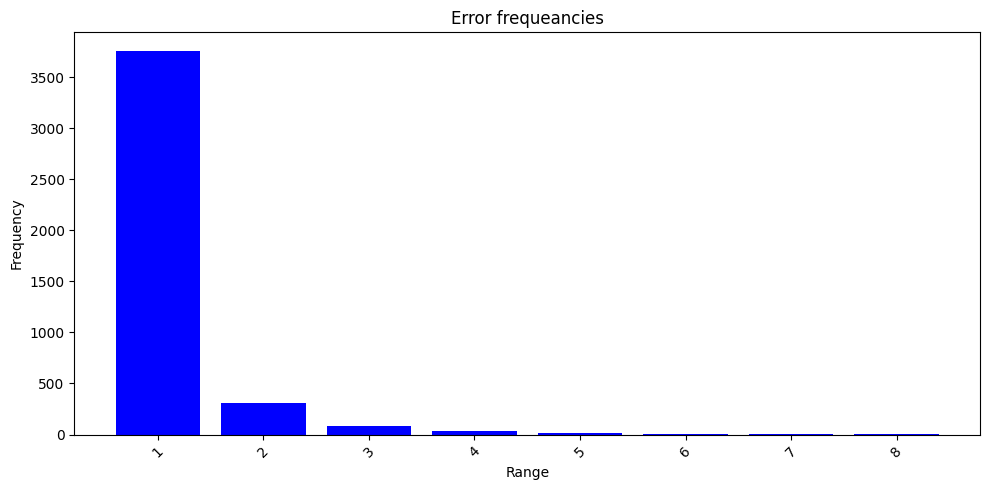

{np.int64(1): np.int64(3752), np.int64(2): np.int64(309), np.int64(3): np.int64(81), np.int64(4): np.int64(32), np.int64(5): np.int64(19), np.int64(6): np.int64(2), np.int64(7): np.int64(1), np.int64(8): np.int64(1)}
Error mean: 1.1586847748391709
Error rate: 10.827614674165421 %
Overall mean: 0.01733656674062226
Accuracy: 0.7924771683607656 
 Precision: 0.7890983962068192 
 Recall: 0.7924771683607656 
 F1 Score: 0.7900804322214612
Confusion Matrix:
 [[ 6352     2   722     0     1  1036     6     0     9]
 [    3   642     2    28   285    40    76   190     0]
 [  843     0  4603     0     2    56     0     0   241]
 [    2    19     1  1389     5    13     4   119     1]
 [    2   219     2     6   979   113   403    37     1]
 [  932    12    46     2    33 12642   408     7     5]
 [    3    47    14     4   282   903  2152    13     0]
 [    3   147     0   133    43    23    15   775     0]
 [    9     0   466     0     0     4     1     0  1184]]


In [26]:
classify(X_train, X_test, y_train, y_test, RandomForestClassifier(random_state=42), classifier_name="RandomForestClassifier")

## SVM

In [27]:
#classify(X_train, X_test, y_train, y_test, SVC(random_state=42), classifier_name="SVC")

## Naive Bayes

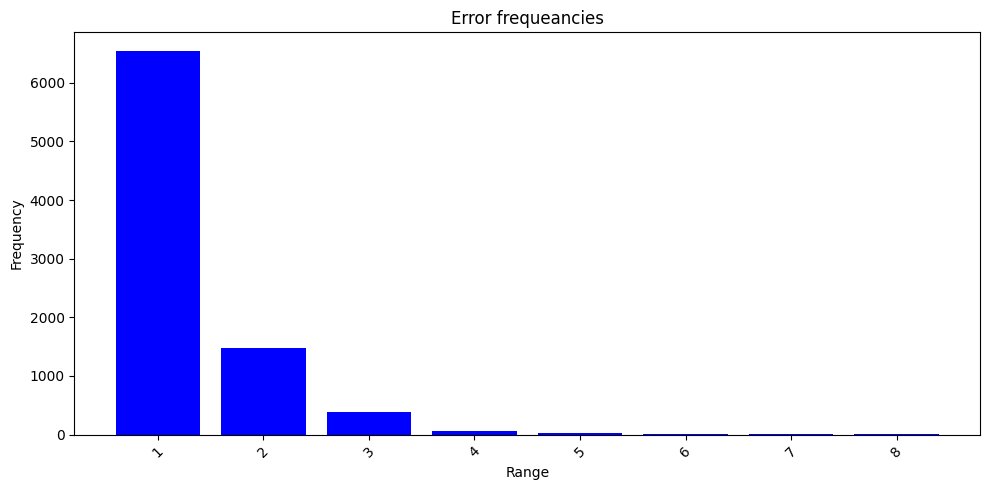

{np.int64(1): np.int64(6533), np.int64(2): np.int64(1482), np.int64(3): np.int64(392), np.int64(4): np.int64(52), np.int64(5): np.int64(26), np.int64(6): np.int64(7), np.int64(7): np.int64(4), np.int64(8): np.int64(3)}
Error mean: 1.306624308742205
Error rate: 21.92611320365306 %
Overall mean: -0.07873690728032609
Accuracy: 0.5345441411691864 
 Precision: 0.5383126401588406 
 Recall: 0.5345441411691864 
 F1 Score: 0.5154125961029565
Confusion Matrix:
 [[ 4093    51   967    51   104  2657    23    26   156]
 [    0   100     7    86   732    97    15   225     4]
 [ 1928    12  2271    31    18   223    11    12  1239]
 [    2    19     4   952   215    17    11   330     3]
 [    1    81     8    60  1001   434    37   138     2]
 [ 1500   118   242   114  1364 10554    48    97    50]
 [   36    73    21    65  1375  1678    55   111     4]
 [    0    50     1   172   580    29     8   299     0]
 [   18     2   232     4     1     8     1     3  1395]]


In [28]:
classify(X_train, X_test, y_train, y_test, GaussianNB(), classifier_name="Naive bayes") # GaussianNB seems to give the best results

## ANN

In [29]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(target[['price_categ']])

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    combustion_cars_encoded, y_encoded, test_size=0.3, random_state=42
)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Define the ANN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Softmax for multi-class classification

# Step 5: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5950 - loss: 1.0650 - val_accuracy: 0.7241 - val_loss: 0.6722
Epoch 2/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - accuracy: 0.7341 - loss: 0.6532 - val_accuracy: 0.7400 - val_loss: 0.6327
Epoch 3/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - accuracy: 0.7519 - loss: 0.6047 - val_accuracy: 0.7450 - val_loss: 0.6158
Epoch 4/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - accuracy: 0.7608 - loss: 0.5834 - val_accuracy: 0.7507 - val_loss: 0.6007
Epoch 5/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - accuracy: 0.7675 - loss: 0.5658 - val_accuracy: 0.7540 - val_loss: 0.5932
Epoch 6/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step - accuracy: 0.7723 - loss: 0.5550 - val_accuracy: 0.7569 - val_loss: 0.5888
Epoch 7/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step - accuracy: 0.7768 - loss: 0.5472 - val_accuracy: 0.7593 - val_loss: 0.5822
Epoch 8/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 873us/step - accuracy: 0.7814 - loss: 0.5

In [30]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

1212/1212 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step


In [31]:
Evaluator.eval_classfication(y_pred=y_pred_classes, y_true=y_test_classes, binary_classification=False, classifier_name="ANN")

Accuracy: 0.7725607553789794 
 Precision: 0.7712947202039577 
 Recall: 0.7725607553789794 
 F1 Score: 0.7717576290892139
Confusion Matrix:
 [[ 6083     1   888     2     5  1128    13     1     7]
 [    4   637     2    21   331    23    62   186     0]
 [  847     0  4430     0     3    51     7     3   404]
 [    2    24     1  1323     6     6     5   186     0]
 [    2   297     1     5   961    51   405    40     0]
 [ 1018    13    25     2    62 12374   580     4     9]
 [    8    55     4     2   378   852  2113     6     0]
 [    2   201     0   124    36     7    19   750     0]
 [   10     0   372     0     0     5     2     0  1275]]


## Regression

In [32]:
X_train, X_test, y_train, y_test = train_test_split(combustion_cars_encoded, target['price'], test_size=0.3, random_state=42)

In [49]:
def regression(X_train, X_test, y_train, y_test , regressor, regressor_name = None) -> None:
    regressor.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = regressor.predict(X_test)
    if regressor_name != None:
        Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name=regressor_name)
    else :Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False)
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    cv_scores = -cross_val_score(regressor, X_test, y_test, cv=5, scoring=mape_scorer)
    Evaluator.plot_bar_chart_key_value(keys= [f"Fold {i+1}" for i in range(len(cv_scores))], values=cv_scores, title=f"Accuracy 5 folder Cross-validation", xlabel="fold", ylabel="accuracy")

### Cart

In [34]:
regression(X_train, X_test, y_train, y_test , DecisionTreeRegressor(random_state=42), regressor_name="CART")

MAE: 2574.102348622403 
 MSE: 60936988.68286733 
 RMSE: 7806.214747421911 
 R2: 0.8624872615785196 
 MAPE: 13.611463141544725
Mean: 2574.102348622403
Variance: 54310985.781683974
Standard Deviation: 7369.5987530993825
r2_adjusted: 0.8623203168374489
MAE: 2574.102348622403 
 MSE: 60936988.68286733 
 RMSE: 7806.214747421911 
 R2: 0.8624872615785196 
 MAPE: 13.611463141544725
Mean: 2574.102348622403
Variance: 54310985.781683974
Standard Deviation: 7369.5987530993825


### Random Forest

In [35]:
regression(X_train, X_test, y_train, y_test , RandomForestRegressor(random_state=42), regressor_name="RandomForest")

MAE: 1963.2356292114837 
 MSE: 29672977.48538812 
 RMSE: 5447.290839067446 
 R2: 0.9330388245410316 
 MAPE: 10.813561650582336
Mean: 1963.2356292114837
Variance: 25818683.349582706
Standard Deviation: 5081.208847270766
r2_adjusted: 0.9329575315915412
MAE: 1963.2356292114837 
 MSE: 29672977.48538812 
 RMSE: 5447.290839067446 
 R2: 0.9330388245410316 
 MAPE: 10.813561650582336
Mean: 1963.2356292114837
Variance: 25818683.349582706
Standard Deviation: 5081.208847270766


### SVM Regression

In [36]:
regression(X_train, X_test, y_train, y_test , SVR(kernel='rbf'), regressor_name="SVR")

MAE: 7792.80004174753 
 MSE: 402609769.8250706 
 RMSE: 20065.13817109343 
 R2: 0.09145540072522251 
 MAPE: 40.96273276974313
Mean: 7792.80004174753
Variance: 341882037.33441037
Standard Deviation: 18490.05238863347
r2_adjusted: 0.09035239932609263
MAE: 7792.80004174753 
 MSE: 402609769.8250706 
 RMSE: 20065.13817109343 
 R2: 0.09145540072522251 
 MAPE: 40.96273276974313
Mean: 7792.80004174753
Variance: 341882037.33441037
Standard Deviation: 18490.05238863347


### Multivariable Regression

In [50]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = linear_regressor.predict(X_test)

# Optionally, display the coefficients of the model
print("Coefficients:", linear_regressor.coef_)
print("Intercept:", linear_regressor.intercept_)

Coefficients: [ 4503.13238718 -4760.94440835  1851.36212853 -3807.47256038
  -552.01517147  1430.44775138  -868.61945716   -47.24364957
 -1152.78321671  2341.53103996 -2048.30341957 -1917.79190677
  1239.50380103 -2224.58487165 -1695.80263199  2433.15695243
 -1755.37217535 -2519.24769035 -1410.58810276  -285.33522183
  2578.46688845  -291.84247316   180.68018198  -402.28656267
  -901.6856687   -591.44996996   935.37558266  -114.31719151
    48.09637989 -1192.12082362   475.7292759   -299.89554621
  1823.88476649  1116.4132613   1040.42083356   129.76347802
  -633.79673138  -812.66396119 -3927.27034419  1464.51519654
   657.38869211  3259.1420991    516.78972822   721.05722265
   562.61082444 -1988.21226899  2696.38329488]
Intercept: 28830.543913029334


In [38]:
result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
result["diff"] = result["Real"].to_numpy() - result["Prediction"].to_numpy()

MAE: 5841.285892619471 
 MSE: 157581663.26057816 
 RMSE: 12553.153518561707 
 R2: 0.6443951939806611 
 MAPE: 38.21187731965349
Mean: 5841.285892619471
Variance: 123461042.38126293
Standard Deviation: 11111.30246106472
r2_adjusted: 0.6439634786868937


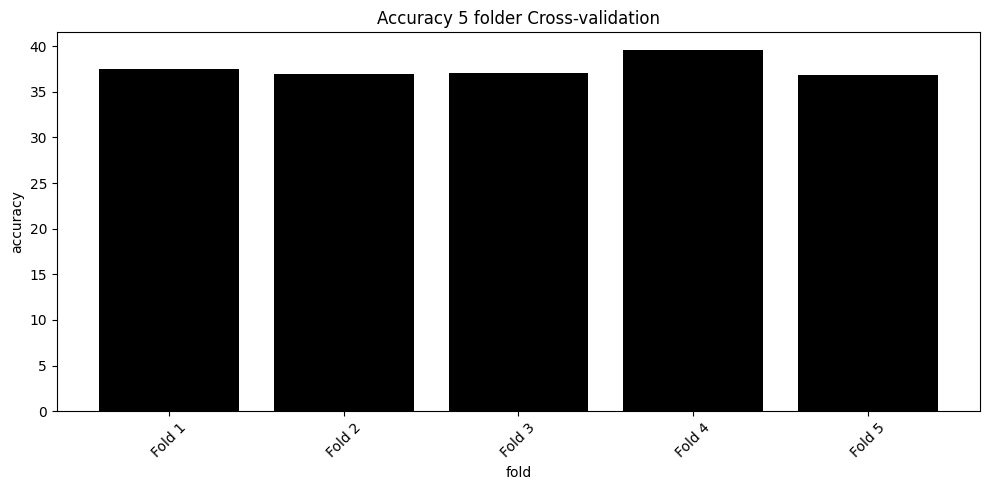

In [51]:
Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name="Lineal Regression")
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
cv_scores = -cross_val_score(linear_regressor, X_test, y_test, cv=5, scoring=mape_scorer)
Evaluator.plot_bar_chart_key_value(keys= [f"Fold {i+1}" for i in range(len(cv_scores))], values=cv_scores, title=f"Accuracy 5 folder Cross-validation", xlabel="fold", ylabel="accuracy")

## ANN

### Regression

In [39]:
# Define the model
model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
model.add(Dense(1))

c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [41]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

Epoch 1/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 474389600.0000 - mae: 12550.5488 - val_loss: 110985664.0000 - val_mae: 4246.3350
Epoch 2/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - loss: 102491568.0000 - mae: 4080.2756 - val_loss: 84536824.0000 - val_mae: 3630.6555
Epoch 3/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 91102160.0000 - mae: 3666.6357 - val_loss: 68768656.0000 - val_mae: 3411.6685
Epoch 4/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - loss: 71548648.0000 - mae: 3361.0291 - val_loss: 57667020.0000 - val_mae: 3170.2422
Epoch 5/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - loss: 50110200.0000 - mae: 3094.2961 - val_loss: 52009324.0000 - val_mae: 3024.1328
Epoch 6/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step - loss: 53210872.0000 - mae: 3013.3335 - val_loss: 49626376.0000 - val_mae: 2893.3811
Epoch 7/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - loss: 47170200.0000 - mae: 2869.7078 - val_loss: 47894844.0000 - val_mae: 2868.4790
Epoch 8/100
7

In [42]:
loss, mae = model.evaluate(X_test, y_test, verbose=2)
print(f"Mean Absolute Error on test set: {mae:.2f}")

1212/1212 - 1s - 476us/step - loss: 31865970.0000 - mae: 2274.2080
Mean Absolute Error on test set: 2274.21


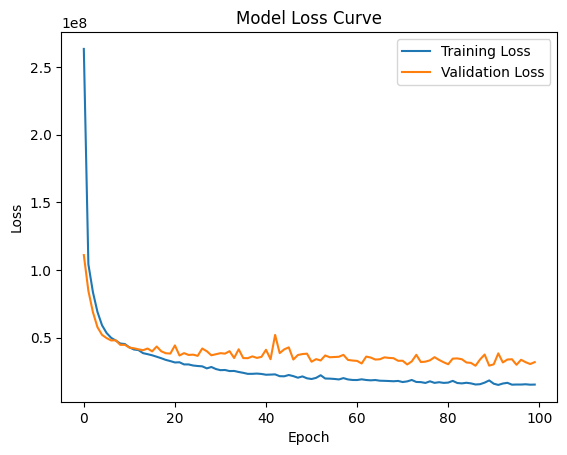

In [43]:
# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Curve')
plt.show()

In [44]:
y_pred = model.predict(X_test).flatten()

1212/1212 ━━━━━━━━━━━━━━━━━━━━ 1s 550us/step


In [45]:
Evaluator.eval_regression(y_pred=y_pred, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name="ANN")

MAE: 2274.207410893963 
 MSE: 31865944.335055918 
 RMSE: 5644.992855182008 
 R2: 0.9280900955200195 
 MAPE: 12.472926230121374
Mean: 2274.207410893963
Variance: 26693924.987290896
Standard Deviation: 5166.6163963749905
r2_adjusted: 0.9280027946595928


,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(99920.0, 0.0]",2038.534055,7.435218e+06,2726.759618,143231.421875,0.117188,38374
1,"(199840.0, 99920.0]",18512.324395,5.254278e+08,22922.211100,167191.500000,67.992188,288
2,"(299760.0, 199840.0]",35243.609140,1.920061e+09,43818.499539,279682.200684,690.281250,77
3,"(399680.0, 299760.0]",74873.935059,5.748969e+09,75821.955487,280111.804688,1175.875000,16


In [52]:
Evaluator.save("combustion")

Regression results saved to: evaluation/combustion_regression.tex
Classification results saved to: evaluation/combustion_classification.tex
